In [1]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

import shutil
shutil.move('/content/kaggle(5)(1)(4).json', '/root/.kaggle/kaggle.json')

from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('ninadaithal/imagesoasis', path='.', unzip=True)


print("Dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
Dataset downloaded and extracted!


In [2]:
import zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from glob import glob

In [3]:
import os
import shutil
import numpy as np

path_1 = '/content/Data/Mild Dementia'
path_2 = '/content/Data/Moderate Dementia'
path_3 = '/content/Data/Non Demented'
path_4 = '/content/Data/Very mild Dementia'

rootdir = '/content/Data'
train_dir = os.path.join(rootdir, 'train')
test_dir = os.path.join(rootdir, 'test')

np.random.seed(42)

classes = {
    '1': 'Mild Dementia',
    '2': 'Moderate Dementia',
    '3': 'Non Demented',
    '4': 'Very mild Dementia'
}

for class_name in classes.values():
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

def split_and_copy_limited(source_path, class_name, train_dest, test_dest, total_limit=488, test_ratio=0.2):
    all_files = os.listdir(source_path)
    all_files = [f for f in all_files if os.path.isfile(os.path.join(source_path, f))]
    np.random.shuffle(all_files)


    limited_files = all_files[:total_limit]

    split_index = int(len(limited_files) * (1 - test_ratio))
    train_files = limited_files[:split_index]
    test_files = limited_files[split_index:]

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))

    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

# Apply the function to all classes
split_and_copy_limited(path_1, 'Mild Dementia', train_dir, test_dir)
split_and_copy_limited(path_2, 'Moderate Dementia', train_dir, test_dir)
split_and_copy_limited(path_3, 'Non Demented', train_dir, test_dir)
split_and_copy_limited(path_4, 'Very mild Dementia', train_dir, test_dir)

print("Balanced train-test split (488 images per class) completed successfully!")


Balanced train-test split (488 images per class) completed successfully!


In [4]:
train_path = '/content/Data/train'
test_path = '/content/Data/test'

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1560 images belonging to 4 classes.
Found 392 images belonging to 4 classes.


In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [8]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation='softmax')
])

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


model.compile(optimizer=Adamax(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 863ms/step - accuracy: 0.3047 - loss: 1.3787 - val_accuracy: 0.4036 - val_loss: 1.3055
Epoch 2/15
 1/48 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.3750 - loss: 1.3160

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3750 - loss: 1.3160 - val_accuracy: 0.4375 - val_loss: 1.2888
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 558ms/step - accuracy: 0.4248 - loss: 1.2658 - val_accuracy: 0.4427 - val_loss: 1.2042
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.5312 - loss: 1.1728 - val_accuracy: 0.4271 - val_loss: 1.2155
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.5061 - loss: 1.1575 - val_accuracy: 0.4766 - val_loss: 1.1690
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5000 - loss: 1.1176 - val_accuracy: 0.4818 - val_loss: 1.1301
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 564ms/step - accuracy: 0.5554 - loss: 1.0448 - val_accuracy: 0.5208 - val_loss: 1.0821
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.5312 - loss: 1.0591 - val_accuracy: 0.5573 - val_loss: 1.0451
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 840ms/step - accuracy: 0.5727 - loss: 1.0057 - val_accuracy: 0.6042 - 

In [9]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size,
    verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - accuracy: 0.6822 - loss: 0.7697
Test Loss: 0.7767283916473389
Test Accuracy: 0.6875


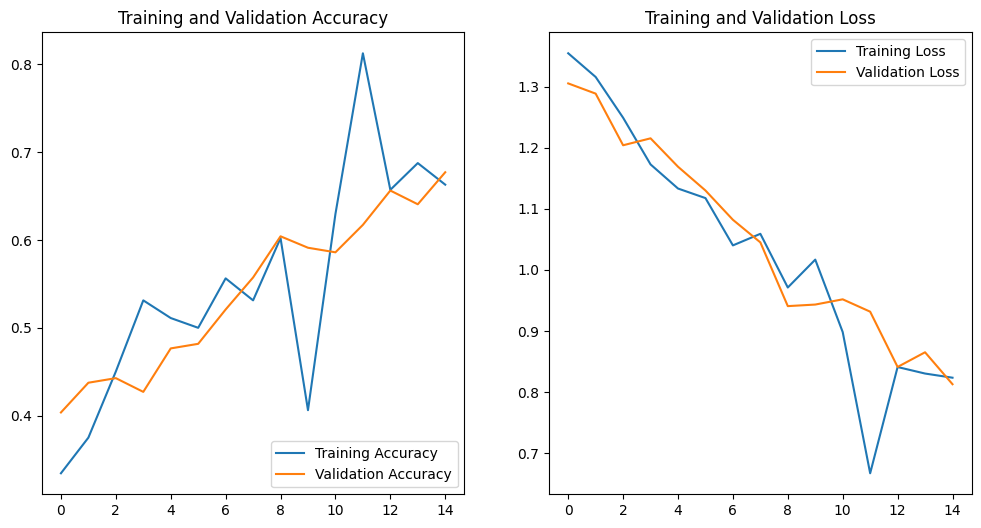

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def plot_confusion_matrix(test_generator, model):

    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)


    cm = confusion_matrix(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_training_history(history)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 698ms/step


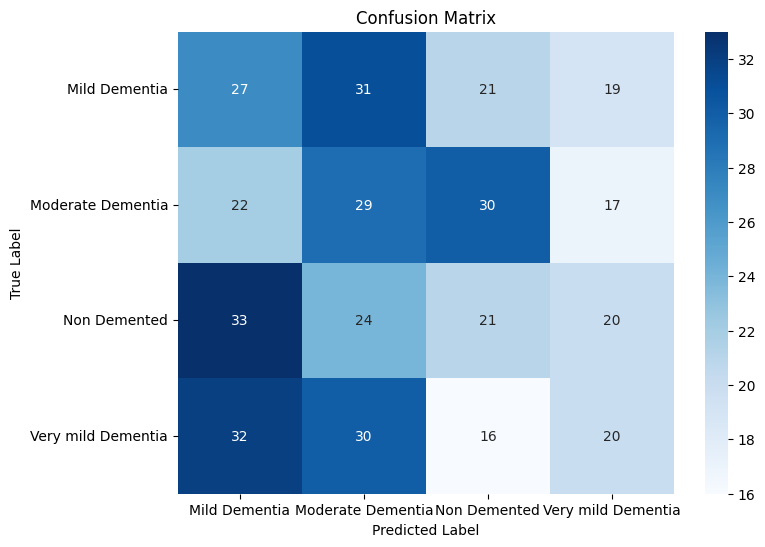

In [11]:
plot_confusion_matrix(test_generator, model)

In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=deaa5a118f2fe208334e11e0a008ceb9ad2f323c9245779cce9400d3d195fa12
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime import lime_image
import shap

In [ ]:

images, labels = next(train_generator)

image = images[0]
label = labels[0]

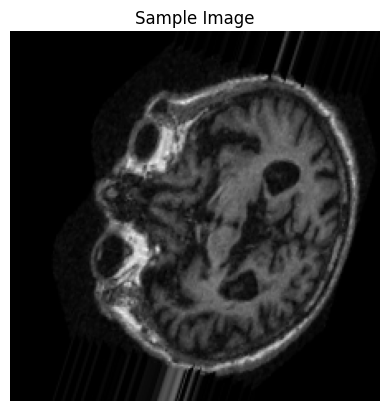

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image_uint8 = (image * 255).astype(np.uint8)

plt.imshow(image_uint8)
plt.title("Sample Image")
plt.axis("off")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

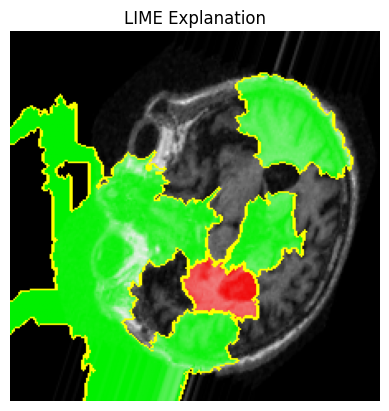

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()


def predict_fn(images):
    return model.predict(images)

explanation = explainer.explain_instance(
    image_uint8,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()


Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


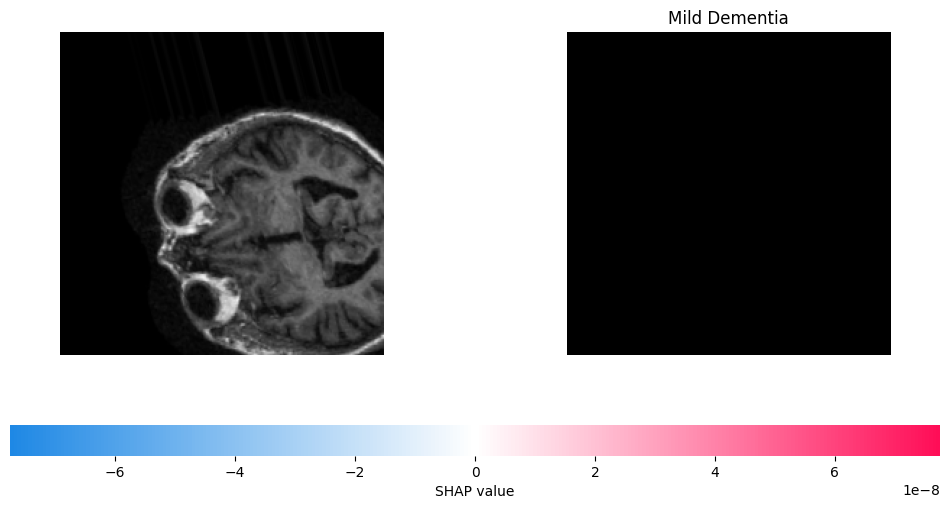

In [ ]:
def explain_with_shap_partition(model, test_generator, class_names):

    test_generator.reset()
    sample_image, _ = next(test_generator)
    sample_image = sample_image[:1]


    masker = shap.maskers.Image("inpaint_telea", sample_image[0].shape)


    explainer = shap.Explainer(
        model.predict,
        masker,
        output_names=class_names,
        max_evals=100
    )


    print("Computing SHAP values...")
    shap_values = explainer(sample_image)


    shap.image_plot(
        shap_values.values,
        sample_image,
        class_names,
        show=False
    )
    plt.gcf().set_size_inches(12, 6)
    plt.show()

explain_with_shap_partition(
    model=model,
    test_generator=test_generator,
    class_names=list(test_generator.class_indices.keys())
)

In [12]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("Generating predictions from original model...")
X_train = []
y_train_true = []
y_train_pred = []

for i in range(len(train_generator)):
    X_batch, y_batch = train_generator[i]
    pred_batch = model.predict(X_batch)
    X_train.append(X_batch)
    y_train_true.append(y_batch)
    y_train_pred.append(pred_batch)
    if i >= train_generator.samples // train_generator.batch_size:
        break

X_train = np.concatenate(X_train)
y_train_pred_labels = np.concatenate(y_train_pred).argmax(axis=1)
y_train_true_labels = np.concatenate(y_train_true).argmax(axis=1)

X_train_flat = X_train.reshape(X_train.shape[0], -1)

print("Training decision tree surrogate...")
tree_surrogate = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

tree_surrogate.fit(X_train_flat, y_train_pred_labels)

train_score = tree_surrogate.score(X_train_flat, y_train_pred_labels)
print(f"Surrogate fidelity (training): {train_score:.3f}")

tree_rules = export_text(
    tree_surrogate,
    feature_names=[f"pixel_{i}" for i in range(X_train_flat.shape[1])],
    max_depth=3
)
print("\nDecision Tree Surrogate Rules:")
print(tree_rules)

feature_extractor = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D()
])
features = feature_extractor.predict(X_train)

print("\nTraining Random Forest surrogate on extracted features...")
rf_surrogate = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)
rf_surrogate.fit(features, y_train_pred_labels)

single_tree = rf_surrogate.estimators_[0]
tree_rules = export_text(
    single_tree,
    feature_names=[f"feature_{i}" for i in range(features.shape[1])],
    max_depth=3
)
print("\nRandom Forest Tree Rules:")
print(tree_rules)

Generating predictions from original model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [13]:
pip install graphviz

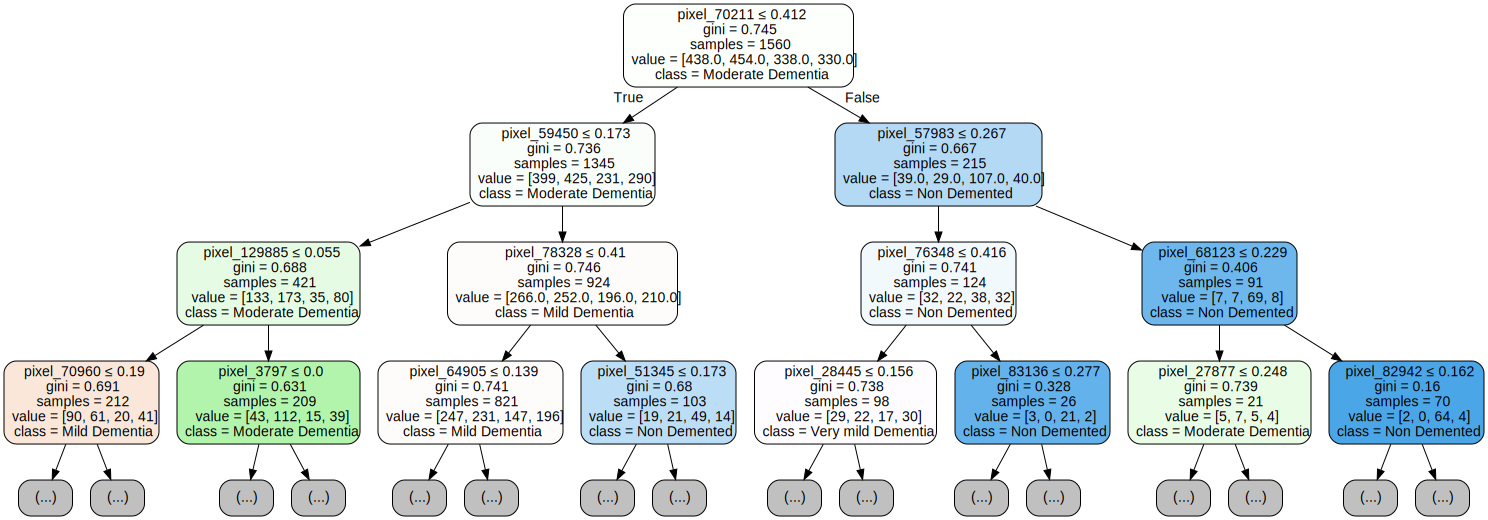

In [14]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    tree_surrogate,
    out_file=None,
    feature_names=[f"pixel_{i}" for i in range(X_train_flat.shape[1])],
    class_names=list(train_generator.class_indices.keys()),
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3
)

graph = graphviz.Source(dot_data)
graph.render("surrogate_tree")
graph